### *Import of Packages and Dataset*

In [183]:
#%pip install --upgrade Pillow -q

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, Normalizer
import statsmodels.formula.api as smf

from sklearn import svm
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import StackingClassifier

from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, classification_report, f1_score 
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, mean_squared_error, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.cluster import KMeans
from kneed import KneeLocator
from scipy.stats import mstats

from PIL import Image
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = 900000000


Load Breast Cancer Wisconsin (Diagnostic) Data Set

In [185]:
df = pd.read_csv("Wisconsin.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### *Preliminary Checks on Dataset*

Check data for any missing values or NaN

In [186]:
#Check for null values
df.info()
print("\n")

#Check for NaN
print(df.isna().any())
print("\n")
print(df.isna().sum())
print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Check for duplicate rows

In [187]:
#Get possible duplicates form dataset and print duplicates with their corresponding index
dupe_counter = 0

for i in df.duplicated().index:
    if df.duplicated()[i] == True:
        print("Index: ", i, "is a duplicate")
        dupe_counter += 1

print(f"There are {dupe_counter} duplicates in the dataset")

There are 0 duplicates in the dataset


Remove unnecessary column "Unnamed: 32"

In [188]:
df.drop(columns=['Unnamed: 32'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [189]:
#Changing column name in dataset to ensure no problems arise due to extra spaces
df = df.rename(columns={'concave points_mean':'concave_points_mean'})

The diagnosis of the breast tissues is either M (malignant) or B (benign). As such, all Ms will be converted to 1s (indicating cancerous tissues) and all Bs will be converted to 0s (indicating non-cancerous tissues).

In [190]:
def binaryMB(text):
    if text == "M":
        text = 1
    
    else:
        text = 0

    return text        

In [191]:
df["diagnosis"] = df["diagnosis"].apply(binaryMB) 

In [192]:
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### *Exploratory Data Analysis (EDA)*

In [193]:
print("Frequency of Benign (0) and Malignant (1) Diagnoses:")
print(df["diagnosis"].value_counts())

print("\n")

print("Percentage of Benign (0) and Malignant (1) Diagnoses:")
print(df["diagnosis"].value_counts(normalize=True).mul(100).round(1))

Frequency of Benign (0) and Malignant (1) Diagnoses:
diagnosis
0    357
1    212
Name: count, dtype: int64


Percentage of Benign (0) and Malignant (1) Diagnoses:
diagnosis
0    62.7
1    37.3
Name: proportion, dtype: float64


For the sake of this study, the dataset was divided into two components: 
The target feature, 'diagnosis', 
and a set of predictor features, which are the features with the "mean" suffix. 

In [194]:
#Ensures that only usable features remain
columns_to_exclude = ['id', 'diagnosis']
columns_to_exclude += [col for col in df.columns if 'mean' not in col]

Next, observe Mean and Standard Deviation of Malignant and Benign cases

In [195]:
df_m = df[df['diagnosis'] == 1]
df_b = df[df['diagnosis'] == 0]

df_m.drop(columns=['id','diagnosis'], inplace=True)
df_b.drop(columns=['id','diagnosis'], inplace=True)

C:\Users\Francis\AppData\Local\Temp\ipykernel_25464\2420928143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.drop(columns=['id','diagnosis'], inplace=True)
C:\Users\Francis\AppData\Local\Temp\ipykernel_25464\2420928143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.drop(columns=['id','diagnosis'], inplace=True)


Malignant

In [196]:
print(df_m.describe(include='all').loc[['mean','std']].iloc[:, 0:10].round(2).transpose())

                          mean     std
radius_mean              17.46    3.20
texture_mean             21.60    3.78
perimeter_mean          115.37   21.85
area_mean               978.38  367.94
smoothness_mean           0.10    0.01
compactness_mean          0.15    0.05
concavity_mean            0.16    0.08
concave_points_mean       0.09    0.03
symmetry_mean             0.19    0.03
fractal_dimension_mean    0.06    0.01


Benign

In [197]:
print(df_b.describe(include='all').loc[['mean','std']].iloc[:, 0:10].round(2).transpose())

                          mean     std
radius_mean              12.15    1.78
texture_mean             17.91    4.00
perimeter_mean           78.08   11.81
area_mean               462.79  134.29
smoothness_mean           0.09    0.01
compactness_mean          0.08    0.03
concavity_mean            0.05    0.04
concave_points_mean       0.03    0.02
symmetry_mean             0.17    0.02
fractal_dimension_mean    0.06    0.01


Next, find the outliers in the features and account for them.
Since the features can be seperated into Benign and Malignant, Outliers may belong to either cases

In [198]:
df_eda = df.iloc[:,1:12]

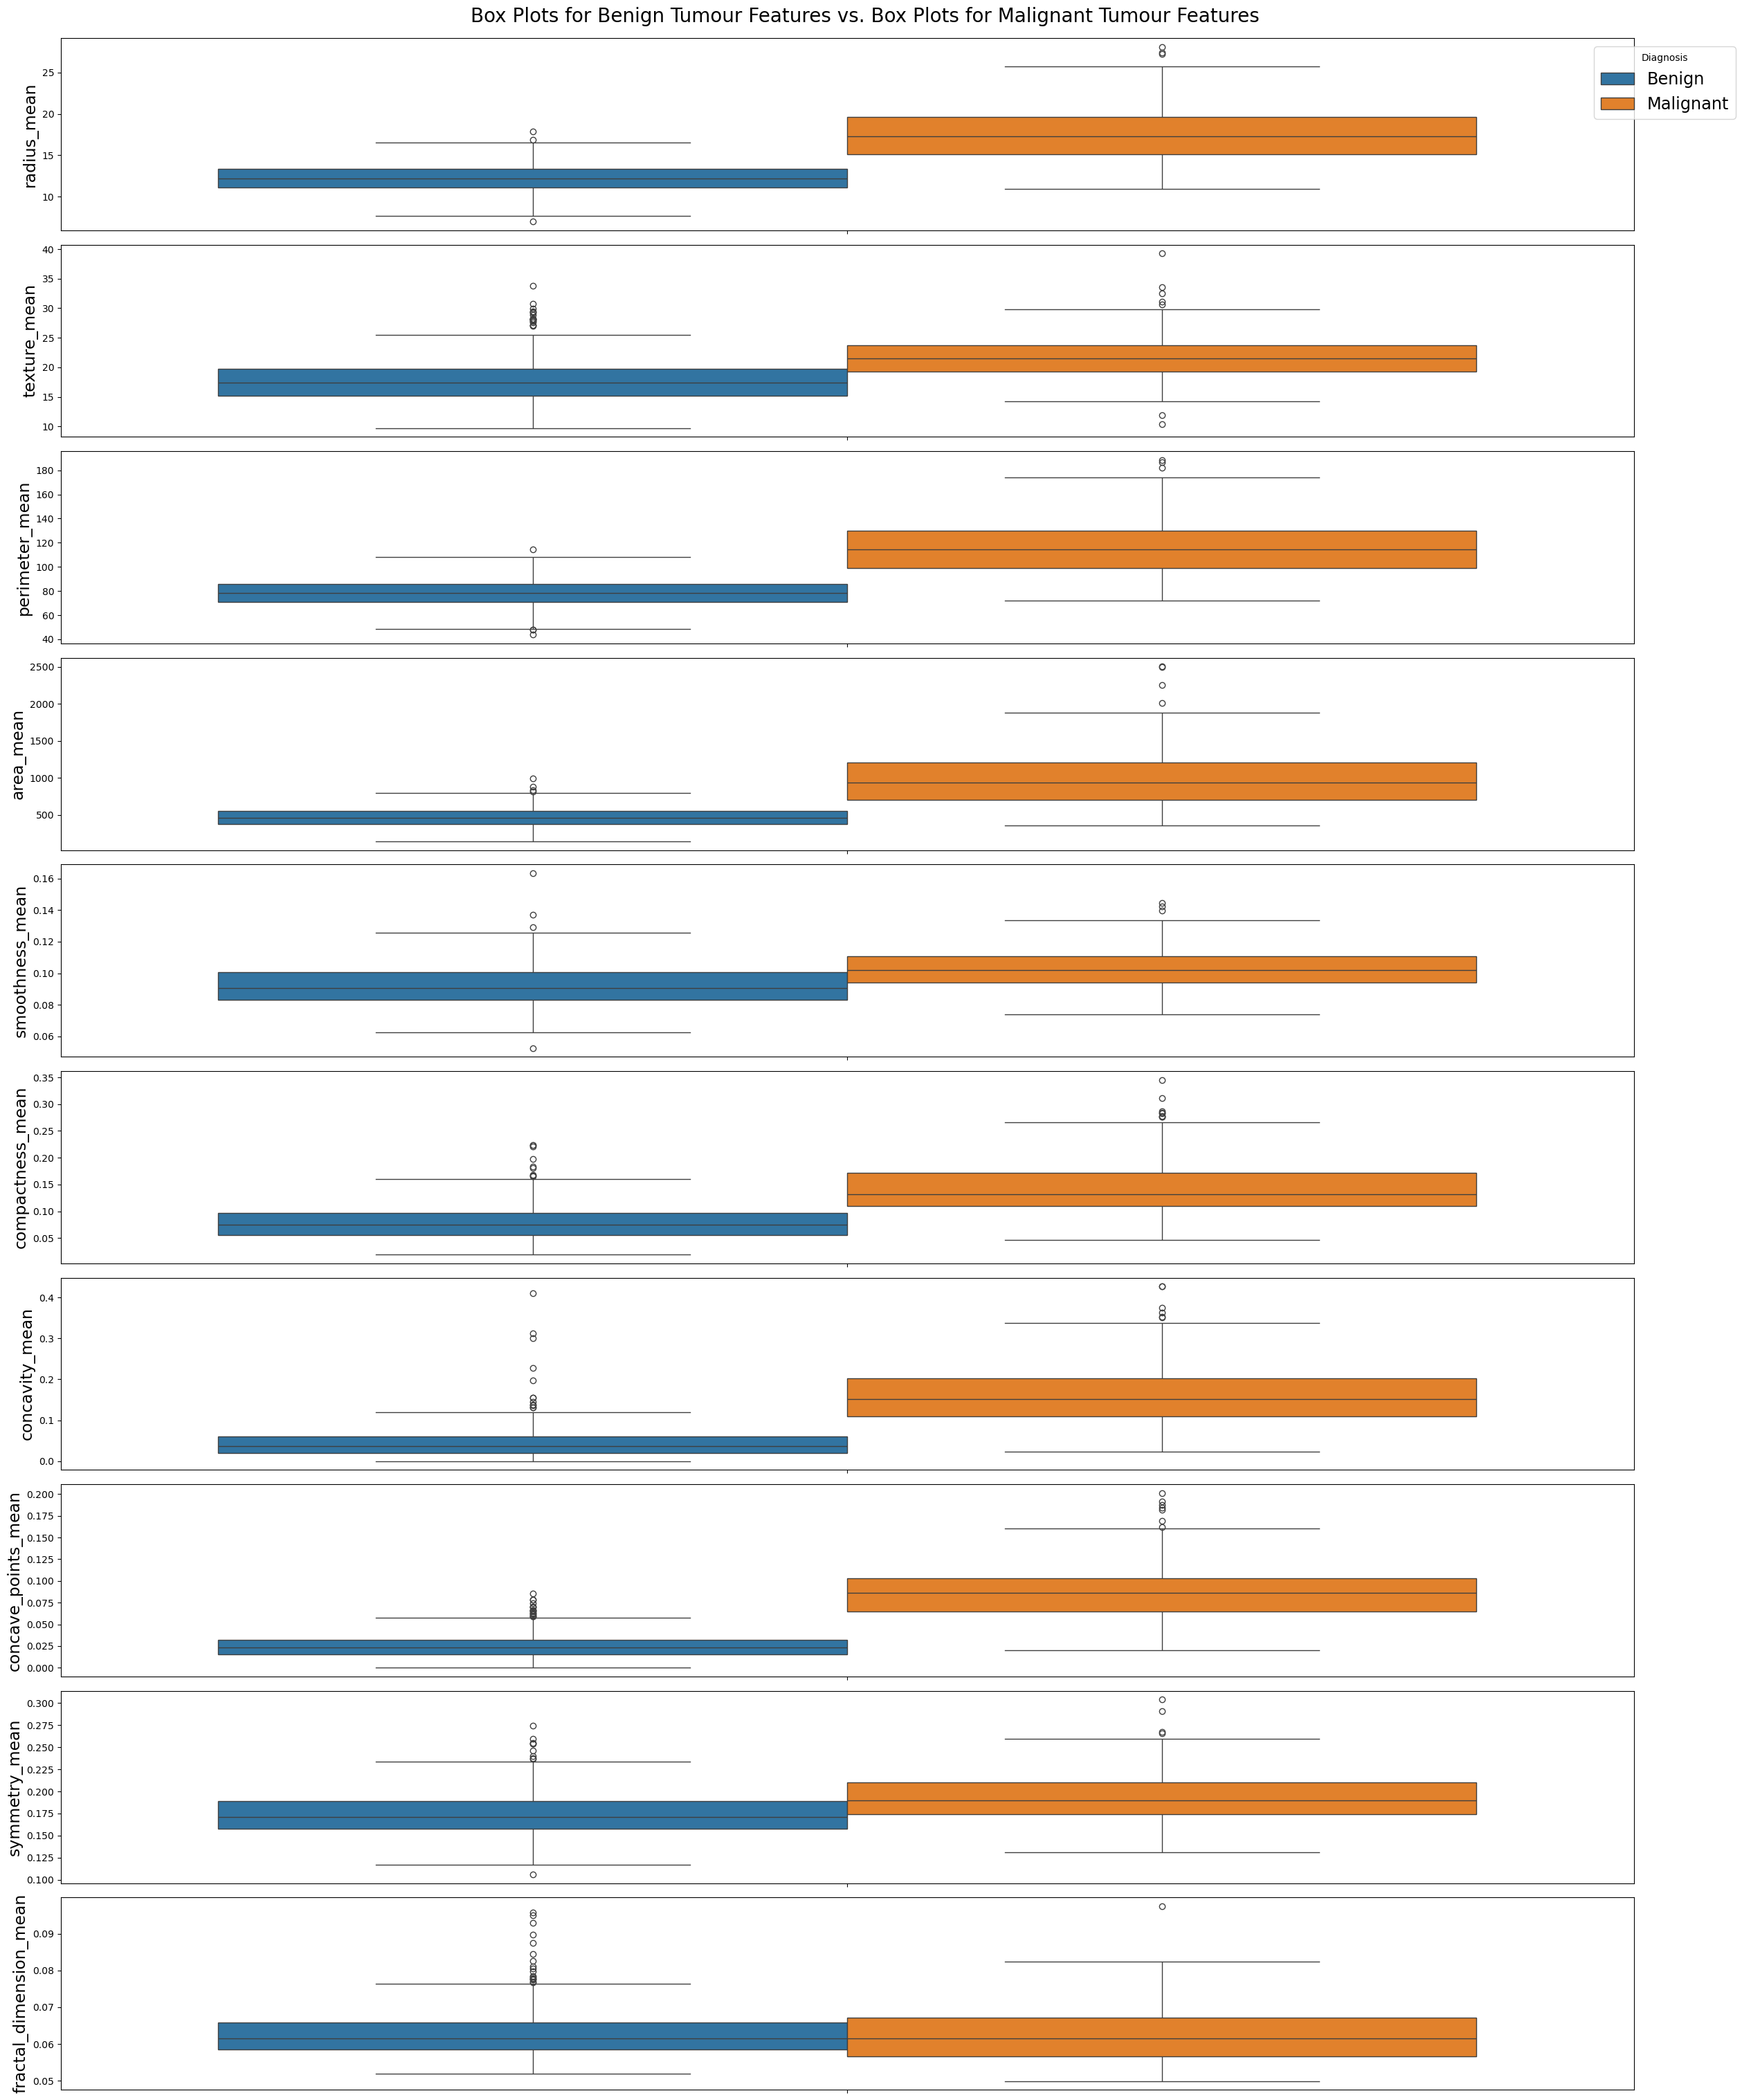

In [199]:
fig, axs = plt.subplots(len(df_eda.columns)-1, 1, figsize=(25, 30))

# Box plots for each feature
for i, feat in enumerate(df_eda.columns):
    if feat != "diagnosis":
        sns.boxplot(data=df_eda, hue="diagnosis", y=feat, ax=axs[i-1]) 
        axs[i-1].set_ylabel(feat, fontsize=17)
        if i == 1:  
            handles, labels = axs[i-1].get_legend_handles_labels()
            axs[i-1].legend(handles, ['Benign', 'Malignant'], title='Diagnosis', loc='upper right', bbox_to_anchor=(1.07, 1), fontsize='xx-large')
           
        else:
            axs[i-1].get_legend().remove()  


plt.tight_layout()
plt.suptitle('Box Plots for Benign Tumour Features vs. Box Plots for Malignant Tumour Features', size=20, y=1.01)
plt.savefig('Box Plots for Benign Tumour Features vs. Box Plots for Malignant Tumour Features.png', bbox_inches='tight')
plt.show()

In [200]:
y = df['diagnosis']

df_m = df_eda[df_eda['diagnosis'] == 1]
df_b = df_eda[df_eda['diagnosis'] == 0]

df_m = df_m.copy()
df_m.drop(columns=['diagnosis'], inplace=True)

df_b = df_b.copy()
df_b.drop(columns=['diagnosis'], inplace=True)

# df_m.drop(columns=['diagnosis'], inplace=True)
# df_b.drop(columns=['diagnosis'], inplace=True)

Now, the outliers will be dealt with using the IQR Method and Winsorization

In [201]:
def find_outliers(df):
    outlier_features = {}
    for col in df.columns:

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
    
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_features[col] = outliers

    print("Number of Outliers in Features: ", outlier_features)
    outlier_sum = sum(outlier_features.values())
    print("Total number of outliers: ", outlier_sum)

In [202]:
find_outliers(df_b)
find_outliers(df_m)

Number of Outliers in Features:  {'radius_mean': 3, 'texture_mean': 18, 'perimeter_mean': 4, 'area_mean': 4, 'smoothness_mean': 4, 'compactness_mean': 9, 'concavity_mean': 12, 'concave_points_mean': 17, 'symmetry_mean': 10, 'fractal_dimension_mean': 17}
Total number of outliers:  98
Number of Outliers in Features:  {'radius_mean': 3, 'texture_mean': 7, 'perimeter_mean': 3, 'area_mean': 4, 'smoothness_mean': 3, 'compactness_mean': 8, 'concavity_mean': 6, 'concave_points_mean': 7, 'symmetry_mean': 4, 'fractal_dimension_mean': 1}
Total number of outliers:  46


In [203]:
winsorized_df_b = df_b.apply(lambda x: mstats.winsorize(x, limits=[0.01, 0.06]))
winsorized_df_m = df_m.apply(lambda x: mstats.winsorize(x, limits=[0.01, 0.06]))

find_outliers(winsorized_df_b)
find_outliers(winsorized_df_m)

Number of Outliers in Features:  {'radius_mean': 0, 'texture_mean': 0, 'perimeter_mean': 0, 'area_mean': 0, 'smoothness_mean': 0, 'compactness_mean': 0, 'concavity_mean': 0, 'concave_points_mean': 0, 'symmetry_mean': 0, 'fractal_dimension_mean': 0}
Total number of outliers:  0
Number of Outliers in Features:  {'radius_mean': 0, 'texture_mean': 0, 'perimeter_mean': 0, 'area_mean': 0, 'smoothness_mean': 0, 'compactness_mean': 0, 'concavity_mean': 0, 'concave_points_mean': 0, 'symmetry_mean': 0, 'fractal_dimension_mean': 0}
Total number of outliers:  0


In [204]:
# Combine df_m and df_b
combined_df = pd.concat([winsorized_df_m, winsorized_df_b])

# Order the combined dataframe by the index
ordered_df = combined_df.sort_index()

# Create a new dataframe with 'y' (df['diagnosis']) as the first column
new_df = pd.concat([y, ordered_df], axis=1)

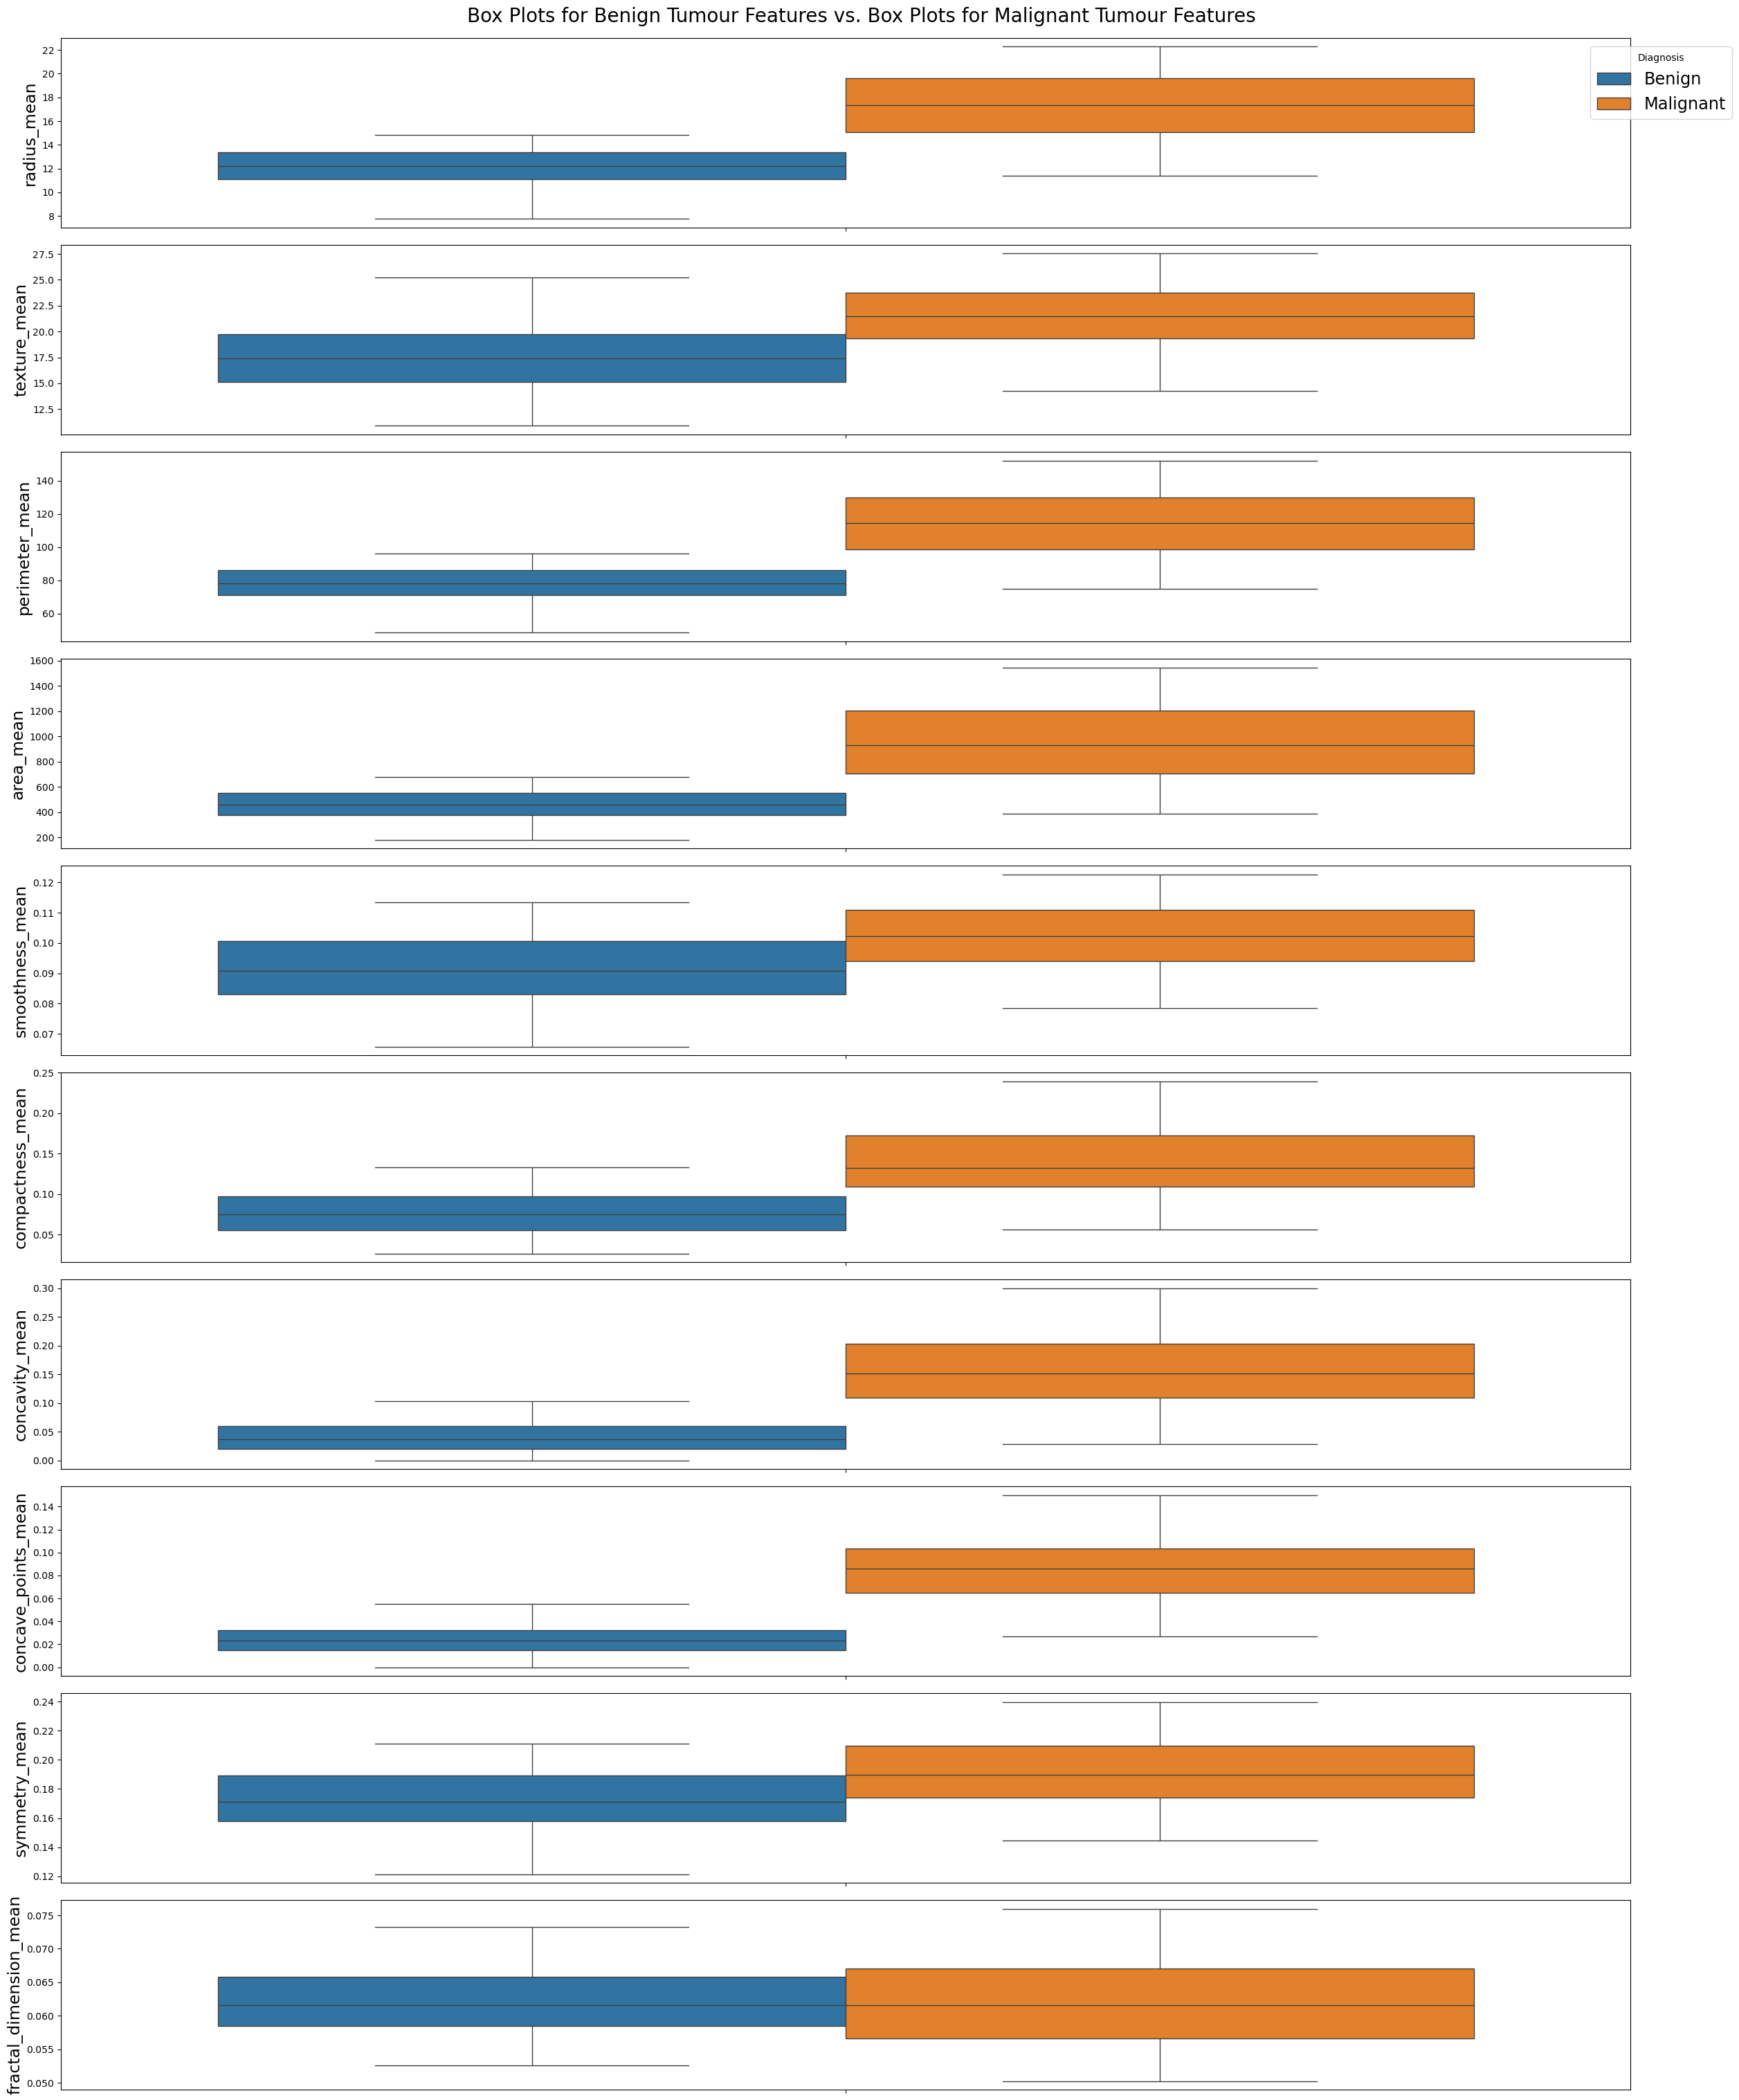

In [205]:
fig, axs = plt.subplots(len(new_df.columns)-1, 1, figsize=(25, 30))

# Box plots for each feature
for i, feat in enumerate(new_df.columns):
    if feat != "diagnosis":
        sns.boxplot(data=new_df, hue="diagnosis", y=feat, ax=axs[i-1]) 
        axs[i-1].set_ylabel(feat, fontsize=17)
        if i == 1:  
            handles, labels = axs[i-1].get_legend_handles_labels()
            axs[i-1].legend(handles, ['Benign', 'Malignant'], title='Diagnosis', loc='upper right', bbox_to_anchor=(1.07, 1), fontsize='xx-large')
           
        else:
            axs[i-1].get_legend().remove()  


plt.tight_layout()
plt.suptitle('Box Plots for Benign Tumour Features vs. Box Plots for Malignant Tumour Features', size=20, y=1.01)
plt.savefig('Box Plots for Benign Tumour Features vs. Box Plots for Malignant Tumour Features after Winsorization.png', bbox_inches='tight')
plt.show()

Check for Normality in Predictors using Histograms

In [206]:
y = new_df['diagnosis']
X = new_df.drop(columns=['diagnosis'])

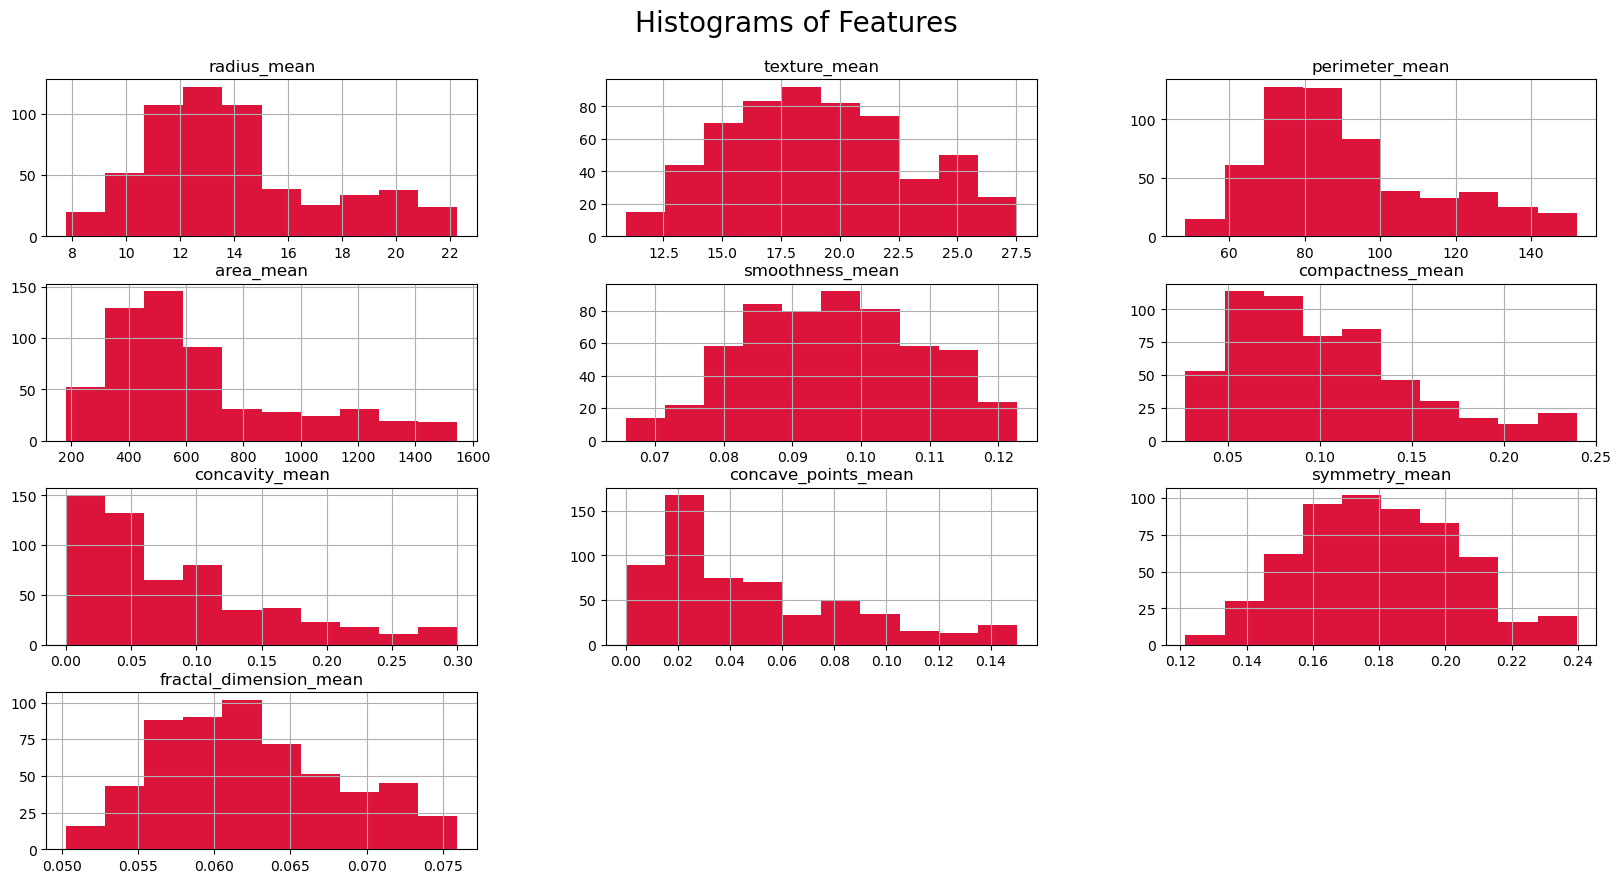

In [207]:
#plot the histograms for each feature:
X.hist(figsize = (20,10), color = 'crimson')
plt.suptitle('Histograms of Features', size=20, y=0.95)
plt.savefig('Histograms of Features.png', bbox_inches='tight', dpi=1000)
plt.show()

To meet the assumption of normailty, the Square Root Transformation was used.

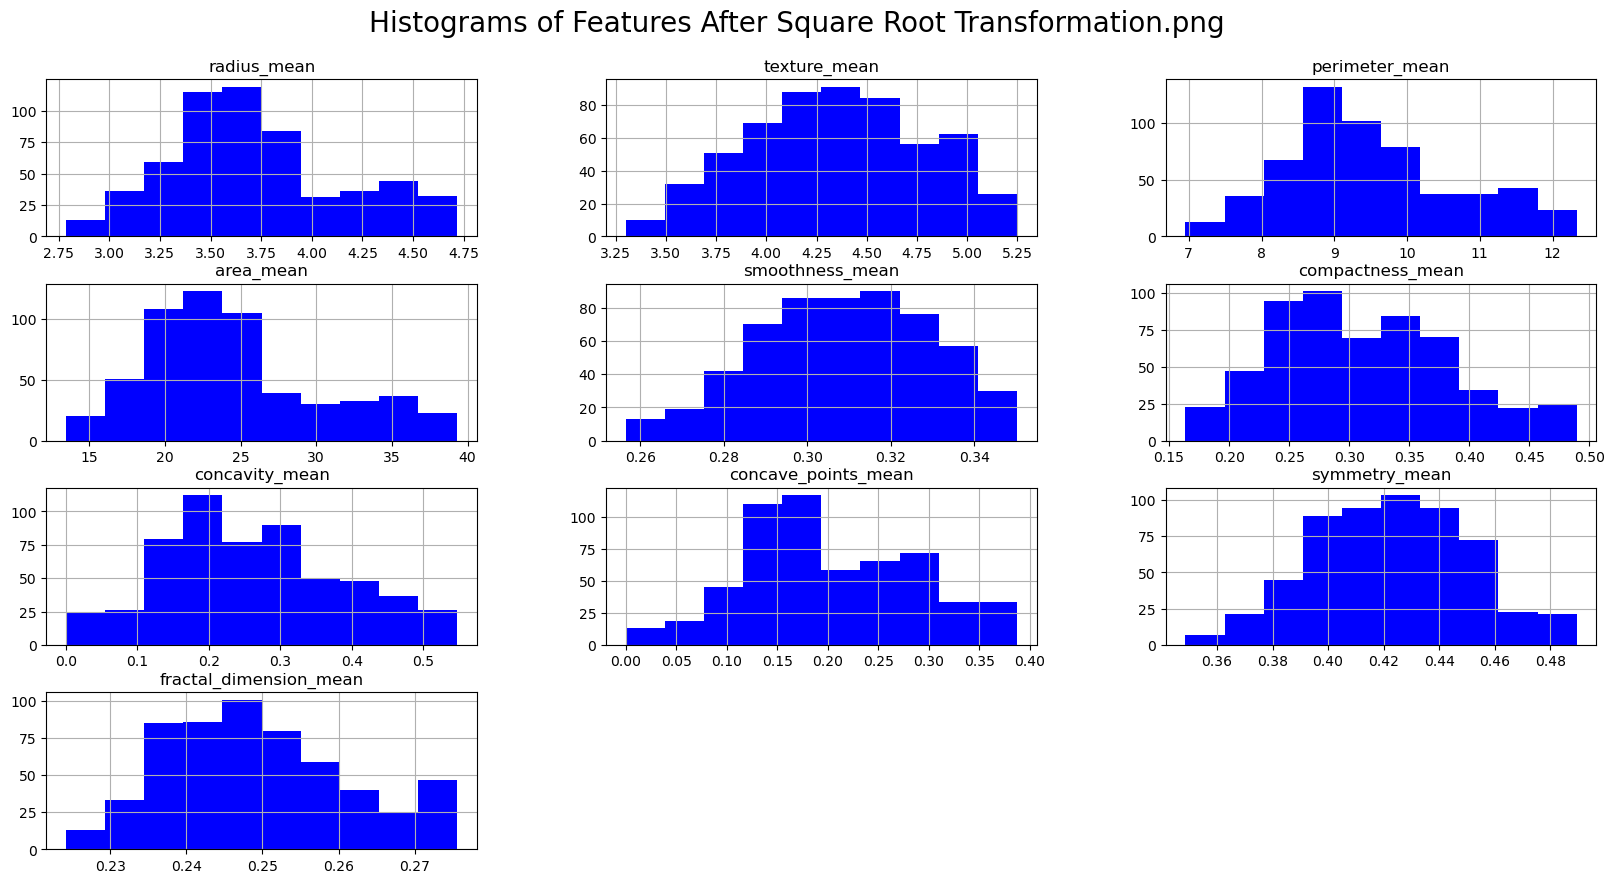

In [208]:
sqrt_X = X.map(np.sqrt)
sqrt_X.hist(figsize = (20,10), color = 'blue')
plt.suptitle('Histograms of Features After Square Root Transformation.png', size=20, y=0.95)
plt.savefig('Histograms of Square Root Features.png', bbox_inches='tight', dpi=1000)
plt.show()

Combine Before and After Graphs

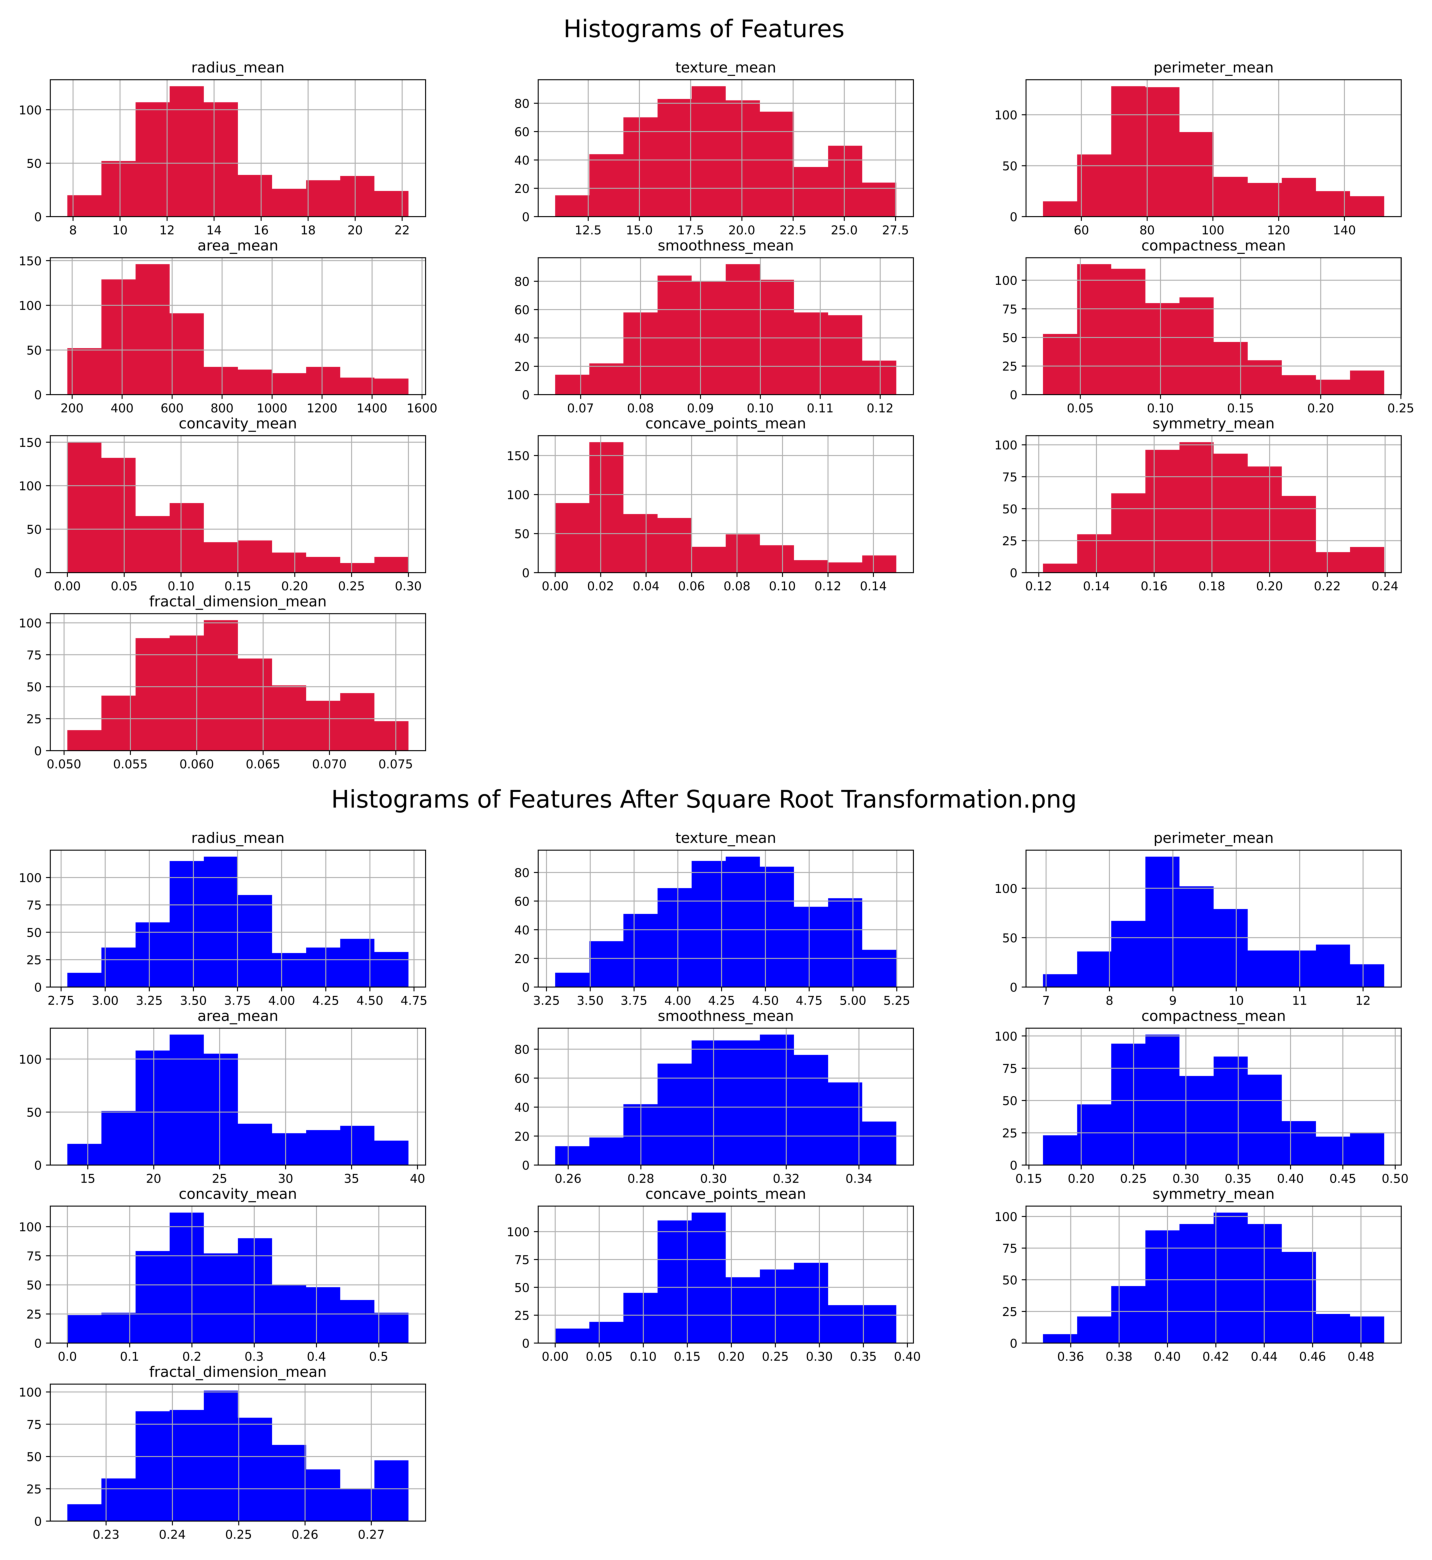

In [209]:
# Open the two images
img1 = Image.open('Histograms of Features.png')
img2 = Image.open('Histograms of Square Root Features.png')

# Calculate the width and height of the output image
width = max(img1.width, img2.width)
height = img1.height + img2.height + 10  # 10 pixels of white space between images

# Create a new image with white background
output_img = Image.new('RGB', (width, height), (255, 255, 255))

# Paste the images onto the output image
output_img.paste(img1, (0, 0))
output_img.paste(img2, (0, img1.height + 10)) 

# Output Image
plt.figure(figsize=(20, 20))
plt.imshow(output_img)
plt.axis('off')  # Turn off axis
plt.show()

# Save the output image
output_img.save('Histograms of Features Before and After Square Root Transformation.png', dpi=(1000, 1000))


Check the Skewness and Kurtosis of the features.

In [210]:
skewness_dict = {feat: skew for feat, skew in zip(sqrt_X.columns, stats.skew(sqrt_X, axis=0, bias=True).round(2))}
print(skewness_dict)

{'radius_mean': 0.47, 'texture_mean': -0.01, 'perimeter_mean': 0.52, 'area_mean': 0.71, 'smoothness_mean': -0.12, 'compactness_mean': 0.42, 'concavity_mean': 0.25, 'concave_points_mean': 0.18, 'symmetry_mean': 0.06, 'fractal_dimension_mean': 0.34}


In [211]:
kurtosis_dict = {feat: skew for feat, skew in zip(sqrt_X.columns, stats.kurtosis(sqrt_X, axis=0, bias=True).round(2))}
print(kurtosis_dict)

{'radius_mean': -0.36, 'texture_mean': -0.64, 'perimeter_mean': -0.29, 'area_mean': -0.18, 'smoothness_mean': -0.59, 'compactness_mean': -0.35, 'concavity_mean': -0.49, 'concave_points_mean': -0.4, 'symmetry_mean': -0.3, 'fractal_dimension_mean': -0.58}


Since the values of skewness and kurtosis are all within the range (-1,1) , the data is approximately normal.

Now, combine y and sqrt_X into a single dataframe to be used in a 2 Sample T-test

In [212]:
combined_df = pd.concat([y, sqrt_X], axis=1)
combined_df['diagnosis'] = combined_df['diagnosis'].map({1: 'M', 0: 'B'})

Save Dataframe for 2 Sample T-test in R Studio

In [213]:
combined_df.to_csv('Winsorized Sqrt Wisconsin.csv', index=False)
combined_df['diagnosis'] = combined_df['diagnosis'].map({'M': 1, 'B': 0})

The R-Code used to test for significant difference reported no significant difference found between the fractal_dimension_mean of Benign and Malignant cases. As such, fractal_dimension_mean will be exluded.

In [214]:
sqrt_X = sqrt_X.drop(columns=['fractal_dimension_mean'])
combined_df = combined_df.drop(columns=['fractal_dimension_mean'])

Furthermore, by showing the correlation between each of the remaining features using a heatmap, features that may lead to multicollinearity can be dealt with.

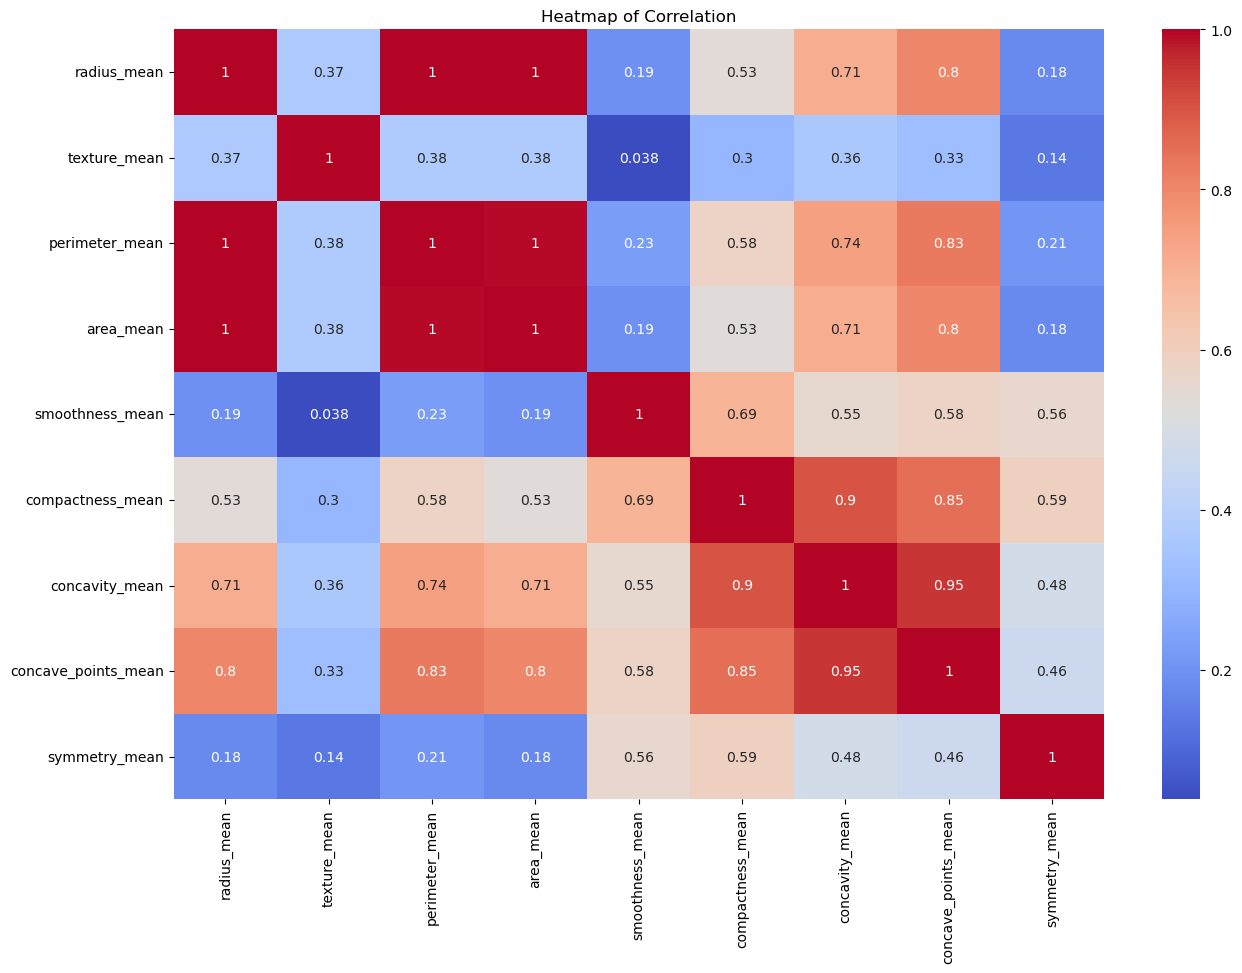

In [215]:
plt.figure(figsize=(15,10))

sns.heatmap(sqrt_X.corr(), annot=True, cmap='coolwarm')

plt.title('Heatmap of Correlation')

plt.savefig('Heatmap.png', bbox_inches='tight', dpi=1000)

plt.show()

In [216]:
# Get the correlation matrix
corr_matrix = sqrt_X.corr()

# Loop through the upper triangle of the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        # Check if the correlation is higher than 0.7
        if corr_matrix.iloc[i, j] >= 0.7:
            # Print the pair of features and their correlation
            print(f"{corr_matrix.columns[i]} and {corr_matrix.columns[j]} have a correlation of {corr_matrix.iloc[i, j].round(2)}")

radius_mean and perimeter_mean have a correlation of 1.0
radius_mean and area_mean have a correlation of 1.0
radius_mean and concavity_mean have a correlation of 0.71
radius_mean and concave_points_mean have a correlation of 0.8
perimeter_mean and area_mean have a correlation of 1.0
perimeter_mean and concavity_mean have a correlation of 0.74
perimeter_mean and concave_points_mean have a correlation of 0.83
area_mean and concavity_mean have a correlation of 0.71
area_mean and concave_points_mean have a correlation of 0.8
compactness_mean and concavity_mean have a correlation of 0.9
compactness_mean and concave_points_mean have a correlation of 0.85
concavity_mean and concave_points_mean have a correlation of 0.95


Next, Construct multiple Binary Logistic Regression Model using the remaining features.  
The goal of this is to observe the p-values of these features and determine which of them is to remain when constructing the final model.  
We will be focusing on models involving perimeter, area, radius, concavity, concave points and compactness as they have been shown to have a correlation of 0.7 and over with each other and this may be a sign of possible collinearity.  

Wald Test:   
Using α = 0.05  
$H_{0}$ : $β_{j}$ = 0 for j = 1, 2, ..., 6  
$H_{1}$ : $β_{j}$ ≠ 0 for j = 1, 2, ..., 6

In [217]:
features = ['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean']

results = []
n = 1
for feat in features:

    formula = 'diagnosis ~ texture_mean + smoothness_mean + symmetry_mean + ' + str(feat)

    glm = smf.logit(formula, data=combined_df).fit()
    
    print("\n")

    print("Formula for BLR ",n," : ",f"\033[1m{formula}\033[0m","\n")
    print(glm.summary())

    print("\n")

    results.append((feat, glm.pvalues[4], glm.prsquared.round(2)))
    n = n+1

Optimization terminated successfully.
         Current function value: 0.132207
         Iterations 10


Formula for BLR  1  :  diagnosis ~ texture_mean + smoothness_mean + symmetry_mean + radius_mean 

                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  569
Model:                          Logit   Df Residuals:                      564
Method:                           MLE   Df Model:                            4
Date:                Thu, 27 Mar 2025   Pseudo R-squ.:                  0.7998
Time:                        14:20:11   Log-Likelihood:                -75.226
converged:                       True   LL-Null:                       -375.72
Covariance Type:            nonrobust   LLR p-value:                9.470e-129
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

C:\Users\Francis\AppData\Local\Temp\ipykernel_25464\228187179.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.append((feat, glm.pvalues[4], glm.prsquared.round(2)))
C:\Users\Francis\AppData\Local\Temp\ipykernel_25464\228187179.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.append((feat, glm.pvalues[4], glm.prsquared.round(2)))
C:\Users\Francis\AppData\Local\Temp\ipykernel_25464\228187179.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

In [218]:
sorted_results = sorted(results, key=lambda x: x[1])

for result in sorted_results:
    print(result)

('concavity_mean', 1.373698823083821e-22, 0.67)
('concave_points_mean', 6.362027870773859e-19, 0.78)
('compactness_mean', 4.9032757281992186e-18, 0.49)
('radius_mean', 1.2298071689843006e-15, 0.8)
('perimeter_mean', 2.7240009903095505e-15, 0.8)
('area_mean', 4.573320372457302e-15, 0.81)


The 6 features each rejected the Null Hypothesis (p-value < 0.05). Thus, each of them is a significant predictor of diagnosis.  
Seeing as area_mean boasted the greatest Pseudo $R^{2}$ at 0.81, it will be our final feature of choice. The other featured will be removed.

In [219]:
combined_df = combined_df.drop(columns=['perimeter_mean', 'radius_mean','concavity_mean', 'concave_points_mean','compactness_mean'])
sqrt_X = sqrt_X.drop(columns=['perimeter_mean', 'radius_mean','concavity_mean', 'concave_points_mean','compactness_mean'])

### *Base Models*

In [220]:
# Seperate data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sqrt_X, y, test_size=0.3, random_state=42)

*K-NN*

In [221]:
best_k = 1
max_accuracy_score = 0

# Testing k from 1 to 25
for k_value in range(1, 26):  
    knn_test = KNeighborsClassifier(n_neighbors = k_value)

    knn_test.fit(X_train, y_train)
    
    y_pred_knn_test = knn_test.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_knn_test)

    # print(f"Accuracy for k = {k_value}: {accuracy}")

    if accuracy > max_accuracy_score:
        max_accuracy_score = accuracy
        best_k = k_value

# Training with the best k on the resampled data
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Predictions and evaluation on the original testing set
y_pred_knn = knn.predict(X_test)

print(f"Best number of neighbors: {best_k}")
print("Classification Report for KNN:")
print(classification_report(y_test, y_pred_knn))

Best number of neighbors: 11
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       108
           1       0.93      0.89      0.91        63

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



*SVM*

In [222]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       108
           1       1.00      0.75      0.85        63

    accuracy                           0.91       171
   macro avg       0.94      0.87      0.89       171
weighted avg       0.92      0.91      0.90       171



*NB*

In [223]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Classification Report for Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       108
           1       0.97      0.95      0.96        63

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



### *Stacking Model*


*KNN  as Final Estimator*

In [224]:
#List of estimators for stacking
estimators = [
    ('svm', svm_model),
    ('nb', nb)
]

#Create model from list and final estimator
stack_model1 = StackingClassifier(estimators=estimators, final_estimator=knn)

# #Fit model
# stack_model1.fit(X_train, y_train)

# #Predictions
# y_pred_stack = stack_model1.predict(X_test)

# print("Classification Report for Stacking:")
# print(classification_report(y_test, y_pred_stack))

In [225]:
# Define the list of evaluation metrics
scoring = {'accuracy', 'precision', 'recall', 'f1'}

print("For Stacking Model 1")
print("\n")

# Set the number of folds for cross-validation
num_folds = 10

# Create a k-fold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and obtain the scores (evaluation metrics)
for score in scoring:

    # Perform cross-validation
    scores = cross_val_score(stack_model1, sqrt_X, y, cv=kfold, scoring = score)

    # if score == 'roc_auc':
    #     for i, n in enumerate(scores):
    #         print(f"Fold {i+1} roc_auc score: {n}")
    #     continue    

    # Print the average score for each metric
    print(f"For {score}, Average Score: {np.mean(scores):.2f}")
    print("\n")

For Stacking Model 1


For recall, Average Score: 0.88


For precision, Average Score: 0.97


For f1, Average Score: 0.92


For accuracy, Average Score: 0.94




The code used for the Roc Auc Curve was adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

Mean AUC: 0.9800
Standard Deviation of AUC: 0.02


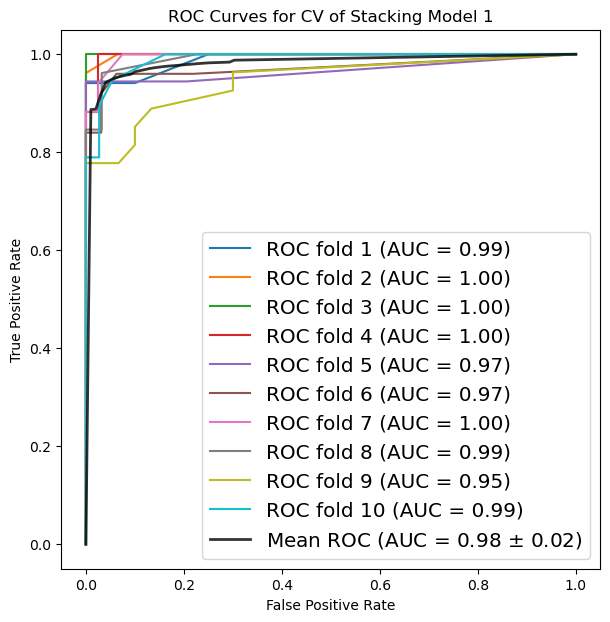

In [226]:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1,1,figsize=(10, 7))
for index, (train, test) in enumerate(kfold.split(sqrt_X, y)):

    stack_model1.fit(sqrt_X.iloc[train], y.iloc[train])
    plot = RocCurveDisplay.from_estimator(
        stack_model1, sqrt_X.iloc[test], y.iloc[test],
        name="ROC fold {}".format(index+1),
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, plot.fpr, plot.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    #print(auc(plot.fpr, plot.tpr))
    aucs.append(plot.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print(f"Mean AUC: {mean_auc:.4f}")
std_auc = np.std(aucs)
print(f"Standard Deviation of AUC: {std_auc:.2f}")


ax.plot(
    mean_fpr,
    mean_tpr,
    color="black",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curves for CV of Stacking Model 1",
)

ax.legend(fontsize='x-large')

plt.savefig('ROC Curve 1.png', bbox_inches='tight', dpi=1000)

plt.show()



*SVM  as Final Estimator*

In [227]:
#List of estimators for stacking
estimators = [
    ('knn', knn),
    ('nb', nb)
]

#Create model from list and final estimator
stack_model2 = StackingClassifier(estimators=estimators, final_estimator = svm_model)

# #Fit model
# stack_model2.fit(X_train, y_train)

# #Predictions
# y_pred_stack = stack_model2.predict(X_test)

# print("Classification Report for Stacking:")
# print(classification_report(y_test, y_pred_stack))

In [228]:
# Define the list of evaluation metrics
scoring = {'accuracy', 'precision', 'recall', 'f1'}

print("For Stacking Model 2")
print("\n")

# Set the number of folds for cross-validation
num_folds = 10

# Create a k-fold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and obtain the scores (evaluation metrics)
for score in scoring:

    # Perform cross-validation
    scores = cross_val_score(stack_model2, sqrt_X, y, cv=kfold, scoring = score)
    
    # if score == 'roc_auc':
    #     for i, n in enumerate(scores):
    #         print(f"Fold {i+1} roc_auc score: {n}")
    #     continue    

    # Print the average score for each metric
    print(f"For {score}, Average Score: {np.mean(scores):.2f}")
    print("\n")

For Stacking Model 2


For recall, Average Score: 0.90


For precision, Average Score: 0.96


For f1, Average Score: 0.93


For accuracy, Average Score: 0.95




The code used for the Roc Auc Curve was adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

Mean AUC: 0.9712
Standard Deviation of AUC: 0.03


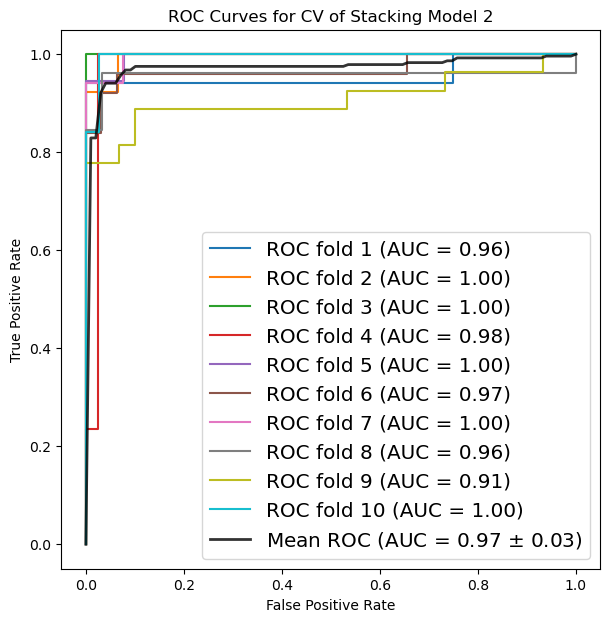

In [229]:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1,1,figsize=(10, 7))
for index, (train, test) in enumerate(kfold.split(sqrt_X, y)):

    stack_model2.fit(sqrt_X.iloc[train], y.iloc[train])
    
    plot = RocCurveDisplay.from_estimator(
        stack_model2, sqrt_X.iloc[test], y.iloc[test],
        name="ROC fold {}".format(index+1),
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, plot.fpr, plot.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    # print(auc(plot.fpr, plot.tpr))
    aucs.append(plot.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print(f"Mean AUC: {mean_auc:.4f}")
std_auc = np.std(aucs)
print(f"Standard Deviation of AUC: {std_auc:.2f}")


ax.plot(
    mean_fpr,
    mean_tpr,
    color="black",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curves for CV of Stacking Model 2",
)

ax.legend(fontsize='x-large')

plt.savefig('ROC Curve 2.png', bbox_inches='tight', dpi=1000)

plt.show()

*NB  as Final Estimator*

In [230]:
#List of estimators for stacking
estimators = [
    ('knn', knn),
    ('svm', svm_model)
]

#Create model from list and final estimator
stack_model3 = StackingClassifier(estimators=estimators, final_estimator = nb) 

# #Fit model
# stack_model3.fit(X_train, y_train)

# #Predictions
# y_pred_stack = stack_model3.predict(X_test)

# print("Classification Report for Stacking:")
# print(classification_report(y_test, y_pred_stack))

In [231]:
# Define the list of evaluation metrics
scoring = {'accuracy', 'precision', 'recall', 'f1'}

print("For Stacking Model 3")
print("\n")

# Set the number of folds for cross-validation
num_folds = 10

# Create a k-fold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and obtain the scores (evaluation metrics)
for score in scoring:

    # Perform cross-validation
    scores = cross_val_score(stack_model3, sqrt_X, y, cv=kfold, scoring = score)
    
    # if score == 'roc_auc':
    #     for i, n in enumerate(scores):
    #         print(f"Fold {i+1} roc_auc score: {n}")
    #     continue    

    # Print the average score for each metric
    print(f"For {score}, Average Score: {np.mean(scores):.2f}")
    
    print("\n")


For Stacking Model 3


For recall, Average Score: 0.87


For precision, Average Score: 0.92


For f1, Average Score: 0.89


For accuracy, Average Score: 0.92




The code used for the Roc Auc Curve was adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

Mean AUC: 0.9597
Standard Deviation of AUC: 0.03


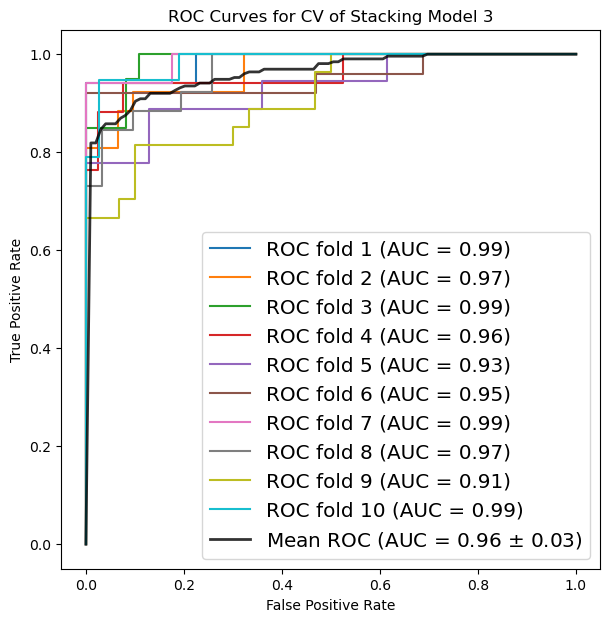

In [232]:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1,1,figsize=(10, 7))
for index, (train, test) in enumerate(kfold.split(sqrt_X, y)):

    stack_model3.fit(sqrt_X.iloc[train], y.iloc[train])
    plot = RocCurveDisplay.from_estimator(
        stack_model3, sqrt_X.iloc[test], y.iloc[test],
        name="ROC fold {}".format(index+1),
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, plot.fpr, plot.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    #print(auc(plot.fpr, plot.tpr))
    aucs.append(plot.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print(f"Mean AUC: {mean_auc:.4f}")
std_auc = np.std(aucs)
print(f"Standard Deviation of AUC: {std_auc:.2f}")


ax.plot(
    mean_fpr,
    mean_tpr,
    color="black",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curves for CV of Stacking Model 3",
)

ax.legend(fontsize='x-large')
plt.savefig('ROC Curve 3.png', bbox_inches='tight', dpi=1000)

plt.show()

In [233]:
# Define the list of evaluation metrics
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Define the list of stacking models
stack_models = [stack_model1, stack_model2, stack_model3]

# Create a dictionary to store the performance metrics for each model
metrics = {}

# Perform cross-validation and obtain the scores (evaluation metrics) for each model
for model in stack_models:
    model_name = f"Stacking Model {stack_models.index(model) + 1}"
    metrics[model_name] = {}
    
    for score in scoring:
        scores = cross_val_score(model, sqrt_X, y, cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring=score)
        metrics[model_name][score] =  "{:.2f}".format(np.mean(scores))

# Create a pandas DataFrame from the metrics dictionary
df = pd.DataFrame(metrics).T

# Display the table in Jupyter Notebook
print("Using 10-fold cross-validation:")
print(df)

Using 10-fold cross-validation:
                 recall precision    f1 accuracy
Stacking Model 1   0.88      0.97  0.92     0.94
Stacking Model 2   0.90      0.96  0.93     0.95
Stacking Model 3   0.87      0.92  0.89     0.92


The following code unites the 3 ROC Curve images and makes them 1 image

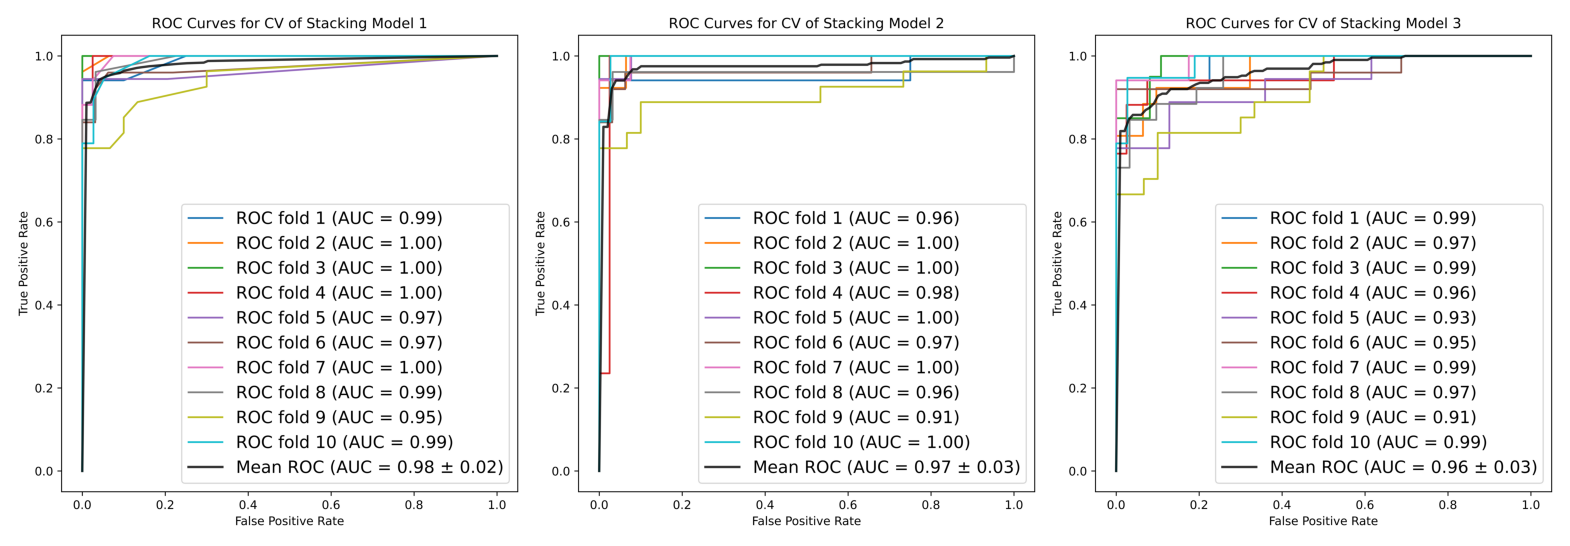

In [234]:
# Open the three images
img1 = Image.open('ROC Curve 1.png')
img2 = Image.open('ROC Curve 2.png')
img3 = Image.open('ROC Curve 3.png')

# Calculate the width and height of the output image and add 10 pixels of white space between images
width = img1.width + img2.width + img3.width + 2 * 10  
height = max(img1.height, img2.height, img3.height)

# Create a new image with white background
output_img = Image.new('RGB', (width, height), (255, 255, 255))

# Paste the images onto the output image
output_img.paste(img1, (0, 0))
output_img.paste(img2, (img1.width + 10, 0))
output_img.paste(img3, (img1.width + img2.width + 20, 0))

#Output Image
plt.figure(figsize=(20, 20))
plt.imshow(output_img)
plt.axis('off') 
plt.show()

#Save the output image
output_img.save('ROC Curves 1, 2, and 3.png', dpi=(1000, 1000))